# CDPQ News Releases NLP
This notebook applies Natural Language Processing (NLP) to the 2018 news releases from La Caisse de dépôt et placement du Québec (https://www.cdpq.com/en/news). The techniques applied include:

- WordCloud of the top words in 2018
- Identification of informative words using Term Frequency-Inverse Document Frequency (TF-IDF)
- Identification of main topics using Latent Dirichlet Allocation (LDA)

In [1]:
import re
import time
import spacy
import requests
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from bs4 import BeautifulSoup
from pathlib import Path
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Directory where the text content will be stored
TEXT_FILES_DIR = 'cdpq_news_nlp'

In [2]:
def extract_content(page_content):
    """Extracts the main content from the page and returns the results in a dictionary."""
    soup = BeautifulSoup(page_content, 'html.parser')
    
    # We are interested only in the title, category, date and the main text (including quotations)
    content = {}
    content['title'] = unicodedata.normalize('NFKD', soup.find(class_='communiques--title').text)
    content['category'] = unicodedata.normalize('NFKD', soup.find(class_='component_content-categorie-ref').text)
    content['date'] = soup.find(class_='component-communiques-metasinfos__date').find('time')['datetime']
    text = ''
    divs = soup.find_all('div', class_='paragraph--type--_col-text')
    for d in divs:
        for p in d.find_all('p'):
            text += unicodedata.normalize('NFKD', p.text) + ' '
    bqs = soup.find_all('blockquote', class_='blockquote--leftborder')
    for bq in bqs:
        for p in bq.find_all('p'):
            text += unicodedata.normalize('NFKD', p.text) + ' '
    content['text'] = text
    return content

def parse_and_save(url, dir):
    """Parses the page specified in the url and stores the content in a text file."""
    page = requests.get(url)
    content = extract_content(page.content)
    page_name = url.split("/")[-1] # Text after the last slash
    
    # Save the main text to a local file
    file_path = (dir / page_name).with_suffix('.txt')
    with open(file_path, 'w+', encoding='utf-8') as file:
        file.write(content['title']+'\n'+content['text'])
    
    # Sleep for 3 seconds
    time.sleep(3)
    print('.', end='')
        
def read_file(file_path):
    "Reads a text file and returns a tuple with the name of the file and the contents of the file."
    with open(file_path, 'r', encoding='utf-8') as file:
        file_name = file_path.stem
        return (file_name, file.read())

# Data Extraction
Connect to the Web server and get the selected news releases, extracting the text content and storing it on local files for feature extraction.

In [3]:
# Read the urls of the news articles
with open('cdpq_news_nlp_urls.txt', 'r') as file:
    news_articles = file.read().split('\n')
    
# Create a directory for the text files (if it doesn't exist)
files_dir = Path.cwd() / TEXT_FILES_DIR
if not files_dir.exists():
    files_dir.mkdir(parents=True)

# Delete any existing text files in the directory
for file in (Path.cwd() / TEXT_FILES_DIR).glob('*.txt'):
    file.unlink()

# Parse the web pages and save the text to disk
for url in news_articles:
    parse_and_save(url, files_dir)

...................................................................

In [4]:
# Read the text files into an array
news_files = (Path.cwd() / TEXT_FILES_DIR).glob('*.txt')
news_name, news_text = zip(*map(read_file, news_files)) # Unzip the names and the text in two different arrays

In [5]:
# Find the total number of words in all the corpus
total_number_of_words = np.sum([len([w for w in re.split('\W', n) if len(w) > 0]) for n in news_text])
print('Number of documents  : {}'.format(len(news_name)))
print('Total number of words: {}'.format(total_number_of_words))

Number of documents  : 67
Total number of words: 41704


# Lemmatization
Lemmatization improves the tokenization of words. It takes into consideration the role of the word on the sentence in order to produce its standardized form. For instance, the words "meeting" and "meet" would produce the same lemma: "meet".

In [6]:
# Custom lemmatization tokenizer
en_nlp = spacy.load('en', disable=['parser', 'ner'])
regexp = re.compile('(?u)\\b\\w\\w+\\b') # Keep the same regex as sklearn
prev_tokenizer = en_nlp.tokenizer
en_nlp.tokenizer = lambda s: prev_tokenizer.tokens_from_list(regexp.findall(s))

def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy if token.lemma_ != '-PRON-'] # Remove the -PRON- token added by spacy

# WordCloud
It is a graphic representation of words where the size of each word is proportional to its frequency.

In [7]:
# CountVectorizer
count_vect = CountVectorizer(ngram_range=(1, 5), min_df=5, strip_accents='ascii', 
                             stop_words='english', tokenizer=custom_tokenizer)
count_vect.fit(news_text)
count_bag_of_words = count_vect.transform(news_text)

features_array = np.array(count_vect.get_feature_names())
count_by_feature = np.asarray(count_bag_of_words.sum(axis=0)).ravel()
highest_count = list(sorted(zip(features_array, count_by_feature), 
                            key=lambda i: i[1], 
                            reverse=True))[:10]

# Print the size of the vocabulary
print('Vocabulary size: {}'.format(len(count_vect.vocabulary_)))

Vocabulary size: 948


## Words with the highest counts

In [8]:
# Display the features with the highest counts
df = pd.DataFrame(highest_count, columns=['Word', 'Count'])
display(df)

,Word,Count
0,caisse,224
1,la,216
2,investment,199
3,quebec,196
4,company,178
5,la caisse,167
6,market,166
7,new,159
8,partner,149
9,year,140


## WordCloud visualization

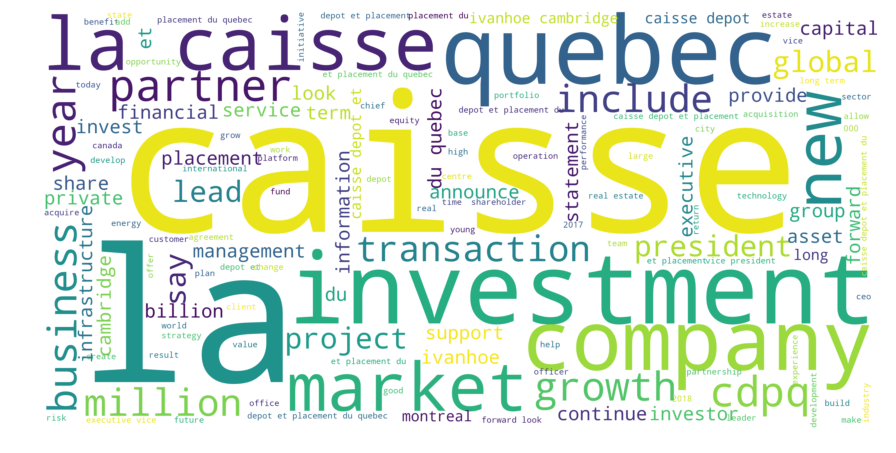

In [9]:
# Display the WordCloud
feature_frequencies = dict(zip(features_array, count_by_feature))
wordcloud = WordCloud(background_color='white', max_words=1000, random_state=0, scale=10)
wordcloud.generate_from_frequencies(feature_frequencies)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Informative words
TF-IDF assigns weights to words based on how informative a word is in a document in relation to all the other documents in the corpus. The algorithm gives higher weights to words that appear often in a particular document, but not in many documents, implying that those words are very descriptive of the content of the document.

In [10]:
# TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 5), min_df=5, strip_accents='ascii', 
                             stop_words='english', tokenizer=custom_tokenizer)
tfidf_vect.fit(news_text)
tfidf_bag_of_words = tfidf_vect.transform(news_text)

# Print the size of the vocabulary
print('Vocabulary size: {}\n'.format(len(tfidf_vect.vocabulary_)))

Vocabulary size: 948



## Top 20 most informative words per document

In [11]:
# Display the most informative words per document from tf-idf
features_array = np.array(tfidf_vect.get_feature_names())
sorting_indices = tfidf_bag_of_words.toarray().argsort()
top_features_per_doc = list(map(lambda features: ', '.join(features_array[features[-20:]]), sorting_indices))

pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({
    'News release name': news_name,
    'Informative words': top_features_per_doc
}, columns=['News release name', 'Informative words'])
display(df.head(10))

,News release name,Informative words
0,ivanhoe-cambridge-acquires-a-9000-m2-office-building-in-nanterre-france,"quality, 000, new, firm, design, high quality, high, fit, perfectly, project, m2, transaction, energy, europe, develop, office, cambridge, ivanhoe cambridge, ivanhoe, building"
1,la-caisse-and-fpjq-create-a-fund-for-future-journalists,"context, note, quebec, financial, help, future, pleased, quality, economic, enable, initiative, fond, pay, citizen, information, caisse, la caisse, professional, la, medium"
2,stingray-acquires-newfoundland-capital-corporation-limited-one-of-canadas,"agreement, include, ability, look, cash, financial, expect, tsx, private, forward, offering, acquisition, information, net, closing, measure, forward look, transaction, share, statement"
3,la-caisse-invests-ca200-million-in-quebec-technology-company-plusgrade,"50, 200, industry, llp, growth, ca, legal, 200 million, revenue, product, associate, team, serve, company, fast, caisse, technology, la, travel, la caisse"
4,la-caisse-provides-financing-to-strengthen-metro-supply-chain-groups-growth,"competitive, capital, service, distribution, national, caisse, la caisse, group, provider, company, traditional, notably, party, arrangement, solution, la, growth, logistic, supply, chain"
5,reseau-express-metropolitain-a-new-website-to-monitor-this-major-project-that,"economic, provide, benefit, new, plan, step, transportation, information, major, various, update, site, citizen, involve, user, project, work, construction, website, rem"
6,cdpq-and-amp-capital-agree-to-provide-up-to-us10-billion-to-finance-tillmans-us,"provide, new, finance, institutional investor, partner, advisor, growth, debt, american, billion, cdpq, future growth, provider, telecommunication, increase, investment, demand, capital, mobile, infrastructure"
7,la-caisse-positions-team-for-the-future,"competitive, identify, responsible, talent, market, la caisse, rem, activity, macky tall, macky, claude, new investment, la, role, position, new, portfolio, head, tall, team"
8,simons-announces-major-investment-in-a-new-state-of-the-art-multi-service,"support, quebec caisse, implement, facility, fond, enable, new, service, order, million, investissement, economy, mr, online, city, multi, digital, quebec, commerce, centre"
9,cdpq-reinvests-eur-100-million-in-spie,"lead global, stephane etroy, stephane etroy executive, stephane etroy executive vice, head private equity cdpq, stephane etroy executive vice president, multi, week, learn, communication, european, independent, continue support, new investment, service, 100, companys, 100 million, million, cdpq"


# Topic identification
The LDA algorithm assign one or multiple topics to each document in the corpus without supervision. It applies decomposition methods to calculate the coefficients of the components for each topic indicating how strongly related a document is to that particular topic.

In [12]:
# CountVectorizer
lda_vect = CountVectorizer(max_df=.15, strip_accents='ascii', 
                             stop_words='english', tokenizer=custom_tokenizer)
lda_vect.fit(news_text)
lda_bag_of_words = lda_vect.transform(news_text)

# Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components=20, learning_method='batch', max_iter=25, random_state=0)
topics = lda.fit_transform(lda_bag_of_words)

print('LDA components shape: {}\n'.format(lda.components_.shape))

LDA components shape: (20, 3482)



## Display the topics and the top 10 related words

In [13]:
# Display the topics and the top 10 releated words in each topic
features_array = np.array(lda_vect.get_feature_names())
sorting_indices = np.argsort(lda.components_, axis=1)[:, ::-1]

def top_topic_features(topic):
    return ', '.join(features_array[sorting_indices[topic]][:10])

topic_features = list(('Topic #{:0>2d}'.format(i), top_topic_features(i)) for i in range(20))
df = pd.DataFrame(topic_features, columns=['Topic name', 'Top 10 related words'])
display(df)

,Topic name,Top 10 related words
0,Topic #00,"return, decathlon, boralex, statement, soleil, cirque, entertainment, net, creactive, family"
1,Topic #01,"quebecor, medium, statement, exchange, convertible, approval, receipt, debenture, press, stock"
2,Topic #02,"kdc, power, cornell, azure, solar, brazil, logistic, ocean, capability, india"
3,Topic #03,"plusgrade, bfl, bouygue, immobilier, fast, france, succession, neighbourhood, nanterre, lorenzetti"
4,Topic #04,"young, avison, gva, rem, poka, advisor, apleona, consultancy, infra, planning"
5,Topic #05,"residential, berlin, solar, round, hill, contourglobal, germany, unit, ca, purchase"
6,Topic #06,"techem, hopper, travel, invenergy, mobile, renewable, ontario, teacher, app, user"
7,Topic #07,"rem, hine, houston, frank, oak, transportation, pelli, site, synnett, tower"
8,Topic #08,"braun, ambulance, alv, fdn, demer, paris, jaclot, alvest, merger, airport"
9,Topic #09,"simon, fulfillment, commerce, agropur, digital, multi, online, order, investissement, dairy"


## Display the news releases and the most strongly related topic

In [14]:
# Display the news releases and the top topic identified for each one
top_topic_per_document = sorted(zip(news_name, ['Topic #{:0>2d}'.format(t.argmax()) for t in topics]), key=lambda i: i[1])
df = pd.DataFrame(top_topic_per_document, columns=['News release name', 'Topic name'])
display(df)

,News release name,Topic name
0,cdpq-reinvests-eur-100-million-in-spie,Topic #00
1,decathlon-is-coming-to-the-montreal-eaton-centre,Topic #00
2,ivanhoe-cambridge-acquires-callahan-capital-properties,Topic #00
3,caisse-de-depot-et-placement-du-quebec-and-fonds-de-solidarite-ftq-will-invest,Topic #00
4,mid-year-update-june-30-2018,Topic #00
5,la-caisse-invests-10-million-in-fx-innovation-a-quebec-leader-in-it,Topic #00
6,cirque-du-soleil-entertainment-group-to-launch-family-entertainment-centres,Topic #00
7,quebecor-and-caisse-de-depot-et-placement-du-quebec-reach-an-agreement-on-the,Topic #01
8,canada-infrastructure-bank-invests-in-reseau-express-metropolitain-project-with,Topic #01
9,cdpq-increases-its-stake-in-azure-power-an-indian-leader-in-solar-power-to-40,Topic #02
